# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [161]:
import numpy as np

ADJACENCY_PATH = '../data/adjacency_matrices/'
ADJACENCY_COSINE_PATH = ADJACENCY_PATH + 'cosine'
ADJACENCY_EUC_PATH = ADJACENCY_PATH + 'eucledian'

In [162]:
adjacency =  np.load(ADJACENCY_COSINE_PATH+'.npy')
n_nodes =  adjacency.shape[0]
n_edges =  np.count_nonzero(adjacency) / 2
senators_adjacency = adjacency.copy()

In [163]:
node_degrees = np.count_nonzero(adjacency, axis=1)

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [164]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [165]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    np.random.seed(seed=seed)
    adjacency = np.random.uniform(0.0, 1.0, size=(n,n))
    adjacency = (adjacency < p).astype(int)
    adjacency = np.tril(adjacency, -1) + np.tril(adjacency, -1).T
    return adjacency

Text(0.5,1.05,'Erdos-Renyi (5, 0.6)')

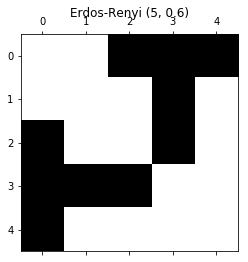

In [166]:
er = erdos_renyi(5, 0.5)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

In [167]:
er

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0]])

Text(0.5,1.05,'Erdos-Renyi (10, 0.4)')

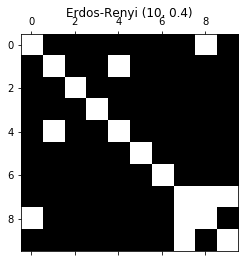

In [168]:
er = erdos_renyi(10, 0.9)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Erdos-Renyi US Senators (n_nodes, p_edge)')

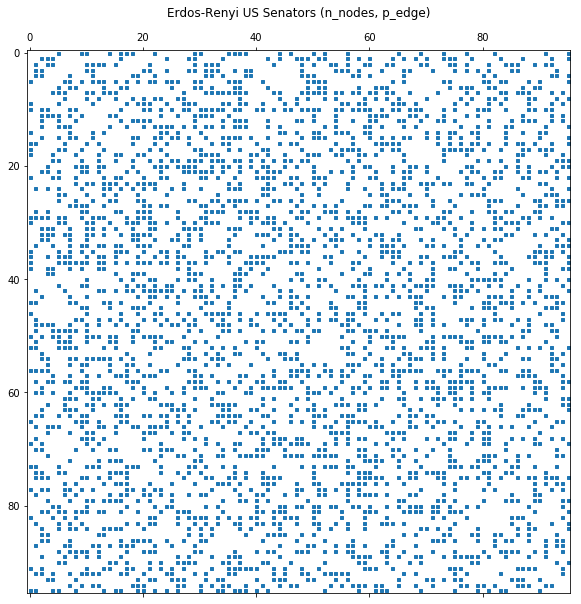

In [169]:
# Your code here.
p_edge  =  n_edges/(n_nodes*(n_nodes-1)/2.0)
erdos_model = erdos_renyi(n_nodes,p_edge)
plt.figure(figsize=(10,10))
plt.spy(erdos_model, markersize=3)
plt.title('Erdos-Renyi US Senators (n_nodes, p_edge)')

In order to be able to compare the graph above to our network,we chose the following parameters for the Erdos-Renyi model:
- We set the  number of nodes to be equal to the number of nodes in our graph
- We set the link probability to be equal to the proportion of edges in our network compared to a fully connected one.


### Question 3

Create a function that constructs a Barabási-Albert graph.

In [170]:
def add_node_and_edges(adjacency, node_nb, m):
    """Add a node to the graph
    
    Parameters
    ----------
    adjacency
        The adjacency matrix of a graph.
    node_nb: int
        node to add
    m: int (optional)
        number of edges that connects the new node to the graph
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    node_degree = np.sum(adjacency[:node_nb],axis = 1)
    total_degrees = np.sum(node_degree)
    nodes_probabilities = node_degree / total_degrees
    new_edges = np.random.choice(node_nb, size=m, p=nodes_probabilities)
    adjacency[node_nb,new_edges] = 1
    adjacency[new_edges,node_nb] = 1

def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    assert m<=m0, "invalid Number of edges to attach from a new node to existing nodes"
    np.random.seed(seed=seed)
    
    # Create graph
    adjacency = np.zeros((n,n))
    
    # Add initial edges
    initial_component = np.zeros((m0,m0))
    for i in range(0, m0-1):
        pick = np.random.choice(list(range(i+1, m0)), size=np.random.randint(1, m0 - i))
        initial_component[i,pick] = 1
    initial_component = initial_component + initial_component.T
    
    adjacency[:m0,:m0] = initial_component
    
    # Iterative adding process
    for step in range(m0, n):
        add_node_and_edges(adjacency, step, m)
        
    
    return adjacency

Text(0.5,1.05,'Barabasi-Albert (5, 1)')

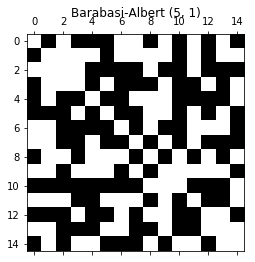

In [171]:
ba = barabasi_albert(15, 10, 10)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

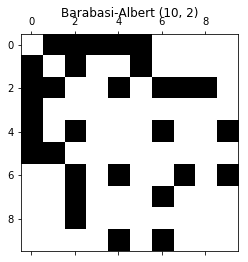

In [172]:
ba = barabasi_albert(10, 2,2)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

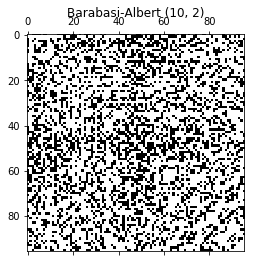

In [180]:
barabasi_model = barabasi_albert(n_nodes, int(np.mean(node_degrees)), int(np.max(node_degrees)))
plt.spy(barabasi_model)
plt.title('Barabasi-Albert (10, 2)')

Since we know that the average degree in a graph generate by the barabase model is $ 2*m $, we  set the number of edges to attach from a new node to existing nodes equal to $ <k> $ where $ <k> $ is the average degree in our network.
## TODO : WHY DID WE CHOOSE M_0 = MAX DEGREE, Also accoding to the formula m should be equal to m/2 but when using this value we get a higher KL-Divergence

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [174]:
n_edges
erdos_renyi_edgecount = np.sum(erdos_model)/2.0
barabasi_edgecount = np.sum(barabasi_model)/2.0

print("The real network has {count} edges.".format(count=n_edges))
print("The Erdős–Rényi model has {count} edges.".format(count=erdos_renyi_edgecount))
print("The Barabási-Albert model has {count} edges.".format(count=barabasi_edgecount))

The real network has 1581.0 edges.
The Erdős–Rényi model has 1611.0 edges.
The Barabási-Albert model has 1720.0 edges.


### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [140]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    mask = np.all([p > 0.0, q > 0.0], axis=0)
    kl = np.sum(np.log(p[mask]/q[mask])*p[mask])
    
    return kl

In [141]:
p_test = np.array([0.2, 0.0, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.0])
kl_divergence(p_test, q_test)

0.057536414490356194

In [157]:
def bin_range_adjust(degrees,binrange,verbose=False):
    ret = binrange.copy()
    dist = np.histogram(degrees, ret,density=False)[0]/len(degrees)
    if verbose:
        print(dist.sum())
    kept_bins = (np.nonzero(dist != 0)[0])
    ret = ret[kept_bins+1] 
    ret = np.insert(ret,0,binrange[0])
    ret[-1] = max(np.max(degrees)+ 1,binrange[-1])

    return ret

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [181]:
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)

erdos_node_degrees = np.count_nonzero(erdos_model, axis=1)
barabasi_node_degrees = np.count_nonzero(barabasi_model, axis=1)
binrange = bin_range_adjust(node_degrees,binrange)
binrange = bin_range_adjust(erdos_node_degrees,binrange)
binrange = bin_range_adjust(barabasi_node_degrees,binrange)

# Compute distributions
real_dist = np.histogram(node_degrees, binrange,density=False)[0]/len(node_degrees)

erdos_dist =  np.histogram(erdos_node_degrees, binrange)[0]/len(node_degrees)
barabasi_dist = np.histogram(barabasi_node_degrees, binrange)[0]/len(node_degrees)
assert np.isclose(np.sum(real_dist), 1)
assert np.isclose(np.sum(erdos_dist), 1)
assert np.isclose(np.sum(barabasi_dist), 1)

# To be reworked with graph that is not limited to 40 degrees
print("KL divergence between real network and Erdos model is {divergence}".format(divergence = kl_divergence(real_dist, erdos_dist)))
print("KL divergence between real network and Barabasi model is {divergence}".format(divergence = kl_divergence(real_dist, barabasi_dist)))

KL divergence between real network and Erdos model is 0.5456465164162987
KL divergence between real network and Barabasi model is 0.3836533164239779


### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

Text(0.5,1,'Degree distribution of nodes in the Barabàsi-Albert model')

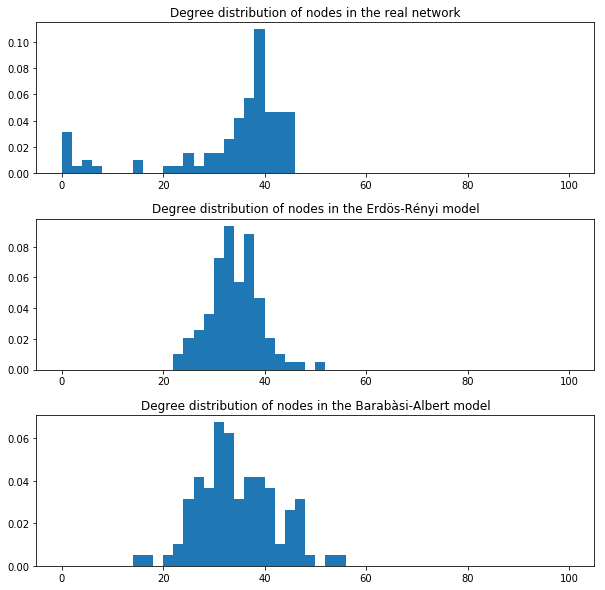

In [182]:
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(3, 1)
f.set_figheight(10)
f.set_figwidth(10)
f.subplots_adjust(hspace=0.3)
binwidth = 2
binrange = np.arange(0, 99 + binwidth, binwidth)
axarr[0].hist(node_degrees, bins=binrange,density=True)
axarr[0].set_title("Degree distribution of nodes in the real network")
axarr[1].hist(erdos_node_degrees, bins=binrange,density=True)
axarr[1].set_title("Degree distribution of nodes in the Erdös-Rényi model")
axarr[2].hist(barabasi_node_degrees, bins=binrange,density=True)
axarr[2].set_title("Degree distribution of nodes in the Barabàsi-Albert model")

### Answer

The resulting histograms are consistent with the KL-divergences computed above. We can see through the histograms above that our network and the Erdös-Rényi graph are skewed around the same range of values and that that their centers are close to each others.The only major difference between the latter distribution is observed for the left distribution tails as our distribution seems to have a heavier left tail compared to the Erdös-Rényi graph. Mainwhile, the degree distribution of the graph generated by the Barabàsi-Albert model  have a heavier right tail and a center which does not match with our network degree distribution.



### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

### Answer 

No, consider the following simple example:

Suppose you have n nodes, with n being a multiple of 3. Connect those nodes such as to form a circle. Clearly, the degree distribution is exactly 2 for each node. 
Now consider another graph made of n nodes where they are split into n/3 small disconnected "triangle" components. The degree distribution is again exactly two per node but the graph exhibits drastically different structures. Therefore, we cannot conclude that two graphs that have identical degree distributions are the same. 

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [20]:
import networkx as nx


In [21]:
G=nx.from_numpy_matrix(adjacency)
nx.write_gexf(G, "test.gexf")

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

### Answer

Let us begin by exaplaining why we believe both the Erdös-Rényi and Barabasi-Albert model are not adapted to our real network.

#### Erdös-Rényi
The Erdös-Rényi model typically shows low clustering coefficient with a degree distribution that converge in distribution to a Poisson distribution. This is not what we observe in our graph.

#### Barabasi-Albert
The Barabasi-Albert model tries to emulate a scale-free network. That is, a network whose degree distribution follows a power law which has a heavy right right.However the degree distribution plotted above shows that our degree distribution does not exhibit such properties.Moreover  with a barabasi Barabasi-Albert model, we expect to have a clustering coefficient close to ${ln(N)}^2/N = 0.21 $  and a few highly connected nodes which is not the case for our setup.   

#### Properties of our network
We identified the following key properties of our network:
1. It exhibits a small-world property. That is, its diameter seems to be proportional to the logarithm of the number of nodes. In milestone 1 we computed a diameter of 3 for ~100 nodes.
2. It has a high level of clustering. Indeed, in milestone 1 we computed a coefficient larger than 0.8
3. Even without being too aggressive during the sparsification procedure, we clearly see that the graph is made of two clusters. The cause is immediate if we look at the labels of the vectors used to compute the similarities. Indeed, the two clusters correspond respectively to demotratic and republican senators.

We therefore opt for the *Watts-Strogatz* model which should typically have the small world property and a high clustering coefficient. We will also try a variant of the Watts-Strogatz where we start with two sets of nodes, corresponding to the democratic and republican clusters.

### Question 11

Explain (in short) how the chosen model works.

### Answer 
The model is characterized by three parameters: 

* N, the number of nodes in the network
* K, the average degree 
* p, a rewiring probability

It is built through the following procedure:

1. We start from a ring network where each node is connected to its K closest neighbors. K/2 at its left and K/2 at its right.
2. We iterate over each link and rewire it with probability p. If a link is rewired we chose the new neighbor uniformly at random (we do not allows for self-loops).

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [22]:
def gen_watts_model(N, K, p):
    adjacency = np.zeros((N,N))
    
    # Build the circle lattice
    for i in range(0,N):
        for neighbor in range(int(-K/2), int(K/2 + 1)):
            adjacency[i, np.mod( i + neighbor, N)] = 1
            
    adjacency = adjacency - np.identity(N)

            
    # Rewire each node with probability p
    for i in range(0,N):
        for neighbor in range(1, int(K/2 + 1)):
            if np.random.choice([True, False], size=1, p=(p, 1-p)):
                candidate_neighbors = [x for x in np.where(adjacency[i] == 0)[0] if x != i ]
                new_neighbor = np.random.choice(candidate_neighbors, size=1)
                adjacency[i, np.mod( i + neighbor, N)] = 0
                adjacency[np.mod( i + neighbor, N), i] = 0
                adjacency[i, new_neighbor] = 1
                adjacency[new_neighbor, i] = 1

    assert np.sum(adjacency) == N * K  
    
    return adjacency

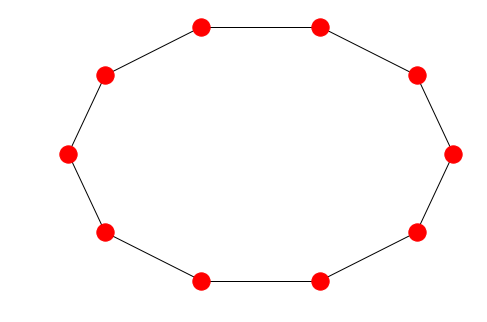

In [23]:
#watts_model = gen_watts_model(10,2,0.0)
watts_model = nx.watts_strogatz_graph(10,2,0.0)
#G=nx.from_numpy_matrix(watts_model)
nx.draw_circular(watts_model)

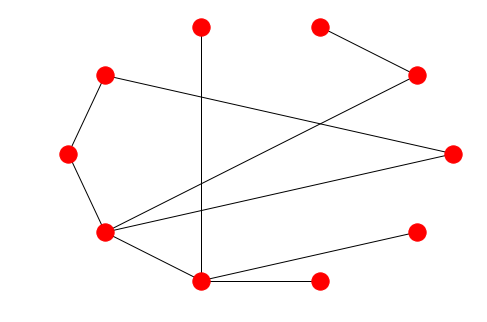

In [24]:
#G=nx.from_numpy_matrix(gen_watts_model(10,2,0.7))
G = nx.watts_strogatz_graph(10,2,0.7)
nx.draw_circular(G)

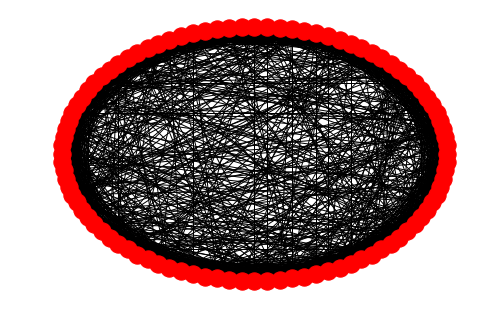

In [25]:
#watts_model = gen_watts_model(50, int(np.mean(node_degrees)), 0.25)
#G=nx.from_numpy_matrix(watts_model)
G = nx.watts_strogatz_graph(len(node_degrees), int(np.mean(node_degrees)), 0.25)
nx.draw_circular(G)

### Question 13

Check the properties you expected to be similar, and compare to your network.

In [ ]:
#watts_node_degrees = np.count_nonzero(watts_model, axis=1)
#
## Compute distributions
#watts_dist =  np.histogram(watts_node_degrees, binrange)[0] / len(watts_node_degrees)
#print("KL divergence: {}".format(kl_divergence(real_dist, watts_dist)))

In [216]:
minimum  = 123333
arg_minimum = 1
arg_minimum_2 = 0
range_it = np.arange(0,1,0.05)
range_it_2 = np.arange(1,int(len(node_degrees)/2),1)

# Seach for best parameters
for idx,i in enumerate(range_it):
        for idx_2,j in enumerate(range_it_2):
            print()
            print('Rewiring probability:',i)
            print('Degree:',j)
            print()
            G = nx.watts_strogatz_graph(len(node_degrees),j , i)
            binrange = np.arange(0, 99 + binwidth, binwidth)
            if len(G.degree) == 0:
                continue
            watts_node_degrees = np.array(G.degree)[:,1]
            # Compute distributions
            binrange = bin_range_adjust(node_degrees,binrange)
            #print(np.nonzero(watts_node_degrees))
            #print(binrange)
            binrange = bin_range_adjust(watts_node_degrees,binrange)
            real_dist = np.histogram(node_degrees, binrange)[0] / len(node_degrees)

            watts_dist = np.histogram(watts_node_degrees, binrange)[0] / len(watts_node_degrees)
            print(binrange,np.unique(watts_node_degrees),np.unique(node_degrees))
            kl_div = kl_divergence(real_dist, watts_dist)
            if kl_div < minimum and arg_minimum < idx:
                minimum = kl_div
                arg_minimum = idx
                arg_minimum_2 = idx_2

            print("KL divergence: {}".format(kl_div))


Rewiring probability: 0.0
Degree: 1


Rewiring probability: 0.0
Degree: 2

[  0 100] [2] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring probability: 0.0
Degree: 3

[  0 100] [2] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring probability: 0.0
Degree: 4

[  0 100] [4] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring probability: 0.0
Degree: 5

[  0 100] [4] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring probability: 0.0
Degree: 6

[  0 100] [6] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring probability: 0.0
Degree: 7

[  0 100] [6] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.0

Rewiring prob

[  0  22  24  26  28 100] [21 22 23 24 25 26 27 28] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.4754868839422834

Rewiring probability: 0.1
Degree: 25

[  0  22  24  26  28 100] [21 22 23 24 25 26 27 28] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.523327648421087

Rewiring probability: 0.1
Degree: 26

[  0  24  26  28  30 100] [22 23 24 25 26 27 28 29 30 31] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.851958650783671

Rewiring probability: 0.1
Degree: 27

[  0  24  26  28 100] [23 24 25 26 27 28 29] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.6659419608948554

Rewiring probability: 0.1
Degree: 28

[  0  26  28  30  32 100] [24 25 26 27 28 29 30 31 34] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence

[  0  24  26  28  30  32 100] [23 24 25 26 27 28 29 30 31 32 33] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.275324048998261

Rewiring probability: 0.15000000000000002
Degree: 30

[  0  24  28  30  32  34 100] [23 26 27 28 29 30 31 32 33 35] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.0845214619674257

Rewiring probability: 0.15000000000000002
Degree: 31

[  0  26  28  30  32  34  36 100] [25 26 27 28 29 30 31 32 33 34 36] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.887105539190623

Rewiring probability: 0.15000000000000002
Degree: 32

[  0  30  32  34  36  38 100] [28 29 30 31 32 33 34 35 36 37 38] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.0098980223939233

Rewiring probability: 0.15000000000000002
Degree: 33

[  0  28  30  32  34  36 100] [27 28 

[  0  22  24  26 100] [19 20 21 22 23 24 25 26 27] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.2209403335673805

Rewiring probability: 0.2
Degree: 24

[  0  22  24  26  28  30 100] [19 20 21 22 23 24 25 26 27 28 29 30] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.280238541476771

Rewiring probability: 0.2
Degree: 25

[  0  22  24  26  28 100] [20 21 22 23 24 25 26 27 28 29] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.8693254903625602

Rewiring probability: 0.2
Degree: 26

[  0  22  24  26  28  30 100] [21 22 23 24 25 26 27 28 29 30 31] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.5864742093937596

Rewiring probability: 0.2
Degree: 27

[  0  22  24  26  28  30  32 100] [21 22 23 24 25 26 27 28 29 30 31 32] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 3

[  0  16  22 100] [14 15 16 17 18 19 20 21 22] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.225456129809236

Rewiring probability: 0.25
Degree: 19

[  0  16  22 100] [13 14 15 16 17 18 19 20 21 22 23] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.8473746725145355

Rewiring probability: 0.25
Degree: 20

[  0  16  22  24 100] [15 16 17 18 19 20 21 22 23 24] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.8270525760669347

Rewiring probability: 0.25
Degree: 21

[  0  16  22  24 100] [15 16 17 18 19 20 21 22 23 24 25] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.060171334245573

Rewiring probability: 0.25
Degree: 22

[  0  22  24  26  28 100] [18 19 20 21 22 23 24 25 26 27 28] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]

Degree: 15

[  0  16 100] [10 11 12 13 14 15 16 17 18 19] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.9839348830113654

Rewiring probability: 0.30000000000000004
Degree: 16

[  0  16  22 100] [12 13 14 15 16 17 18 19 20 21 22] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.614486222519809

Rewiring probability: 0.30000000000000004
Degree: 17

[  0  16  22 100] [12 13 14 15 16 17 18 19 20 21 23] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.62250336366272

Rewiring probability: 0.30000000000000004
Degree: 18

[  0  16  22 100] [13 14 15 16 17 18 19 20 21 22 23] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.5869898525351025

Rewiring probability: 0.30000000000000004
Degree: 19

[  0  16  22  24 100] [12 14 15 16 17 18 19 20 21 22 23 24] [ 0  1  3  4  5  7 14 

[  0   8  16 100] [ 7  8  9 10 11 12 13 14 15 16 19] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.8242740734041063

Rewiring probability: 0.35000000000000003
Degree: 14

[  0  16 100] [10 11 12 13 14 15 16 17 18 19] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.9839348830113654

Rewiring probability: 0.35000000000000003
Degree: 15

[  0  16 100] [ 9 10 11 12 13 14 15 16 17 18 19 21] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.9839348830113654

Rewiring probability: 0.35000000000000003
Degree: 16

[  0  16 100] [11 12 13 14 15 16 17 18 19 20 21] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.16836802771336687

Rewiring probability: 0.35000000000000003
Degree: 17

[  0  16  22 100] [11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  3  4  5  7 14 15 20 23 24 27 28

[  0  34  36  38  40  42  44 100] [32 34 35 36 37 38 39 40 41 42 43 44 47] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.9026421623803935

Rewiring probability: 0.4
Degree: 39

[  0  32  34  36  38  40  42  44 100] [31 32 33 34 35 36 37 38 39 40 41 42 43 45 46] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.36871095096472584

Rewiring probability: 0.4
Degree: 40

[  0  34  36  38  40  42  44 100] [33 34 35 36 37 38 39 40 41 42 43 44 46 47 48 50] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6222464063538794

Rewiring probability: 0.4
Degree: 41

[  0  36  38  40  42  44 100] [34 35 36 37 38 39 40 41 42 43 44 45 47 48] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.32902150889253245

Rewiring probability: 0.4
Degree: 42

[  0  34  36  38  40  42  44 100] [32 33

[  0  38  40  42  44 100] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 56] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.0298771386377648

Rewiring probability: 0.45
Degree: 47

[  0  40  42  44 100] [38 40 41 42 43 44 45 46 47 48 49 50 51 52 53] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.288772690989192

Rewiring probability: 0.5
Degree: 1


Rewiring probability: 0.5
Degree: 2

[  0   2   4 100] [1 2 3 4 5] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.3515677533708175

Rewiring probability: 0.5
Degree: 3

[  0   2   4 100] [1 2 3 4] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.3788147171730833

Rewiring probability: 0.5
Degree: 4

[  0   4   6   8 100] [2 3 4 5 6 7 8] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 4

[  0  30  32  34  36  38  40  42  44 100] [29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.5341391943346514

Rewiring probability: 0.5
Degree: 38

[  0  30  32  34  36  38  40  42  44 100] [29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6146234267308992

Rewiring probability: 0.5
Degree: 39

[  0  32  34  36  38  40  42  44 100] [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.5214329185945413

Rewiring probability: 0.5
Degree: 40

[  0  34  36  38  40  42  44 100] [32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 49 54] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.42573436147673094

Rewiring probability: 0.5
Degree: 41



[  0  24  26  28  30  32  34  36  38  40 100] [23 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.440335255550509

Rewiring probability: 0.55
Degree: 33

[  0  26  28  30  32  34  36  38  40 100] [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 44] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.245204461205044

Rewiring probability: 0.55
Degree: 34

[  0  28  30  32  34  36  38  40 100] [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.8329480832243279

Rewiring probability: 0.55
Degree: 35

[  0  26  28  30  32  34  36  38  40  42 100] [25 27 29 30 31 32 33 34 35 36 37 38 39 40 41 47] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.0414821747159408

Rewiring probability: 

[  0  16  22  24  26  28  30 100] [14 15 17 18 19 20 21 22 23 24 25 26 27 28 29 30] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.4466684401957846

Rewiring probability: 0.6000000000000001
Degree: 24

[  0  22  24  26  28  30  32 100] [18 19 20 21 22 23 24 25 26 27 28 29 31 37] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.9901582370080324

Rewiring probability: 0.6000000000000001
Degree: 25

[  0  22  24  26  28  30 100] [18 19 20 21 22 23 24 25 26 27 28 29 30 31] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.607134323188859

Rewiring probability: 0.6000000000000001
Degree: 26

[  0  22  24  26  28  30  32 100] [19 20 21 22 23 24 25 26 27 28 29 30 31 33] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.0940894033568083

Rewiring probability: 0.6000000000000001

[  0  32  34  36  38  40  42  44 100] [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.3719821582923547

Rewiring probability: 0.65
Degree: 40

[  0  32  34  36  38  40  42  44 100] [30 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 51] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6395993839707547

Rewiring probability: 0.65
Degree: 41

[  0  32  34  36  38  40  42  44 100] [30 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.4951045534248793

Rewiring probability: 0.65
Degree: 42

[  0  38  40  42  44 100] [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 52] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.8264236855984742

Rewiring probability: 0.65
Degree: 43

[

[  0  34  36  38  40  42  44 100] [33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 51] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.0025112203799462

Rewiring probability: 0.7000000000000001
Degree: 44

[  0  36  40  42  44 100] [34 35 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54 55] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.0949923607518517

Rewiring probability: 0.7000000000000001
Degree: 45

[  0  38  40  42  44 100] [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.2675629018521957

Rewiring probability: 0.7000000000000001
Degree: 46

[  0  38  40  42  44 100] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 54] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 2.0593254507802587

Rewiring probability: 0.70

[  0  26  28  30  32  34  36  38  40 100] [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.5863464262519886

Rewiring probability: 0.75
Degree: 34

[  0  26  28  30  32  34  36  38  40  42 100] [25 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.7131785238265358

Rewiring probability: 0.75
Degree: 35

[  0  30  32  34  36  38  40  42 100] [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6341750127644624

Rewiring probability: 0.75
Degree: 36

[  0  28  30  32  34  36  38  40  42  44 100] [27 28 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.4266320186219245

Rewiring proba

[  0  30  32  34  36  38  40  42  44 100] [29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6305133477253531

Rewiring probability: 0.8
Degree: 37

[  0  28  30  32  34  36  38  40  42  44 100] [26 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 46] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.4615274070531286

Rewiring probability: 0.8
Degree: 38

[  0  32  34  36  38  40  42  44 100] [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.4676563892523805

Rewiring probability: 0.8
Degree: 39

[  0  30  34  36  38  40  42  44 100] [28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 54] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.39817638063810856

Rewiring probab

[  0  36  38  40  42  44 100] [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 53] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.8279257415090753

Rewiring probability: 0.8500000000000001
Degree: 43

[  0  38  40  42  44 100] [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 53] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.6844786556808472

Rewiring probability: 0.8500000000000001
Degree: 44

[  0  36  38  40  42  44 100] [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.0887969622378568

Rewiring probability: 0.8500000000000001
Degree: 45

[  0  34  40  42  44 100] [33 38 39 40 41 42 43 44 45 46 47 48 49 50 57] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.4615553362946612

Rewiring probability: 0.85000

[  0   4   6   8 100] [2 3 4 5 6 7 8 9] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 3.155775899150461

Rewiring probability: 0.9500000000000001
Degree: 6

[  0   4   6   8 100] [ 3  4  5  6  7  8  9 10] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.1021357391103623

Rewiring probability: 0.9500000000000001
Degree: 7

[  0   4   6   8 100] [ 3  4  5  6  7  8  9 10] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.3440754521488634

Rewiring probability: 0.9500000000000001
Degree: 8

[  0   6   8 100] [ 4  5  6  7  8  9 10 11 12 13 14] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.32262790533684993

Rewiring probability: 0.9500000000000001
Degree: 9

[  0   6   8 100] [ 4  5  6  7  8  9 10 11 12 13] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 3

[  0  34  36  38  40  42  44 100] [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.42583190353848066

Rewiring probability: 0.9500000000000001
Degree: 42

[  0  36  38  40  42  44 100] [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 0.8559578149973508

Rewiring probability: 0.9500000000000001
Degree: 43

[  0  36  38  40  42  44 100] [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.2447932288761416

Rewiring probability: 0.9500000000000001
Degree: 44

[  0  36  38  40  42  44 100] [35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51] [ 0  1  3  4  5  7 14 15 20 23 24 27 28 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45]
KL divergence: 1.5738095558430287

Rewiring probabilit

In [213]:
len(G.degree)

0

In [215]:
minimum,range_it[arg_minimum],degree

(0.0005495585582418489, 0.6000000000000001)

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(watts_node_degrees, bins=binrange)

Are the results what you expected? Explain.

**Your answer here.**